# Images straight to feature extractor

In this notebook we extract features as points and perform tests on them.

In [1]:
from enum import Enum
from pathlib import Path
from itertools import chain
from matplotlib import pyplot as plt

import numpy as np
import cv2

from skimage import feature
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from sklearn.ensemble import AdaBoostClassifier

np.random.seed(42)

TFEID_COLOR_PATH = Path('data/dfh_all/dfh_color/')

class Expression(Enum):
    ANGER = 1
    CONTEMPT = 2
    DISGUST = 3 
    FEAR = 4
    HAPPINESS = 5
    NEUTRAL = 6
    SADNESS = 7
    SURPRISE = 8

folder = {
    Expression.ANGER     : Path('dfh_anger_c'),
    Expression.CONTEMPT  : Path('dfh_contempt_c'),
    Expression.DISGUST   : Path('dfh_disguest_c'),
    Expression.FEAR      : Path('dfh_fear_c'),
    Expression.HAPPINESS : Path('dfh_happiness_c'),
    Expression.NEUTRAL   : Path('dfh_neutral_c'),
    Expression.SADNESS   : Path('dfh_sadness_c'),
    Expression.SURPRISE  : Path('dfh_surprise_c'),
}    
    
def read_images_expr(path:Path, expr:Expression):
    images = []
    labels = []
    expr_path = path.joinpath(folder[expr])
    for img_path in expr_path.iterdir():
        img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        labels.append(expr.value)
    return images, labels

def read_images(path):
    images, labels = [], []
    for expr in Expression:
        expr_images, expr_labels = read_images_expr(path, expr=expr)
        print(expr, len(expr_images), len(expr_labels))
        images+=expr_images
        labels+=expr_labels
    return images, labels

tfeid_images, tfeid_labels = read_images(TFEID_COLOR_PATH)

Expression.ANGER 34 34
Expression.CONTEMPT 68 68
Expression.DISGUST 40 40
Expression.FEAR 40 40
Expression.HAPPINESS 40 40
Expression.NEUTRAL 39 39
Expression.SADNESS 39 39
Expression.SURPRISE 36 36


In [2]:
def show_metrics(model, pred_y, test_x, test_y):
    print(f'Accuracy: {accuracy_score(test_y, pred_y)}')
    expr_names = [expr.name for expr in Expression]
    plot_confusion_matrix(model, test_x, test_y,
                          display_labels=np.array(expr_names),
                          xticks_rotation=45.0)
    plt.show() 
    print(classification_report(test_y,pred_y,
                                target_names=expr_names,
                                zero_division=0))

In [3]:
np.random.seed(42)

""" TO DO """
def preprocess_single(img):
    img = cv2.resize(img, (400,400))
    return img

def preprocess(images):
    return np.array([preprocess_single(img) for img in images])
    
def hog(img):
    fd = feature.hog(img, orientations=8,
                     pixels_per_cell=(18,18), # changing these parameters gave increase of accurace form 42 to 54%
                     cells_per_block=(2,2),
                     block_norm='L2',
                     feature_vector=True)

    hist, _ = np.histogram(fd.ravel(),bins= 1000,)
    hist = hist.astype(np.float)
    hist /= (np.sum(hist)+1e-5)

    return hist

def lbp(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    numpoints = 14
    radius = 4
    lbp = feature.local_binary_pattern(img, numpoints, radius)

    hist, _ = np.histogram(lbp.ravel(), bins= numpoints+3)
    hist = hist.astype(np.float)
    hist /= (np.sum(hist)+1e-5)

    return hist


def extract_features(images, method):
    return np.array([method(img) for img in images])


tfeid_x = preprocess(tfeid_images)
tfeid_x = extract_features(tfeid_x, method=hog)
tfeid_labels = np.array(tfeid_labels)

train_x, test_x, train_y, test_y = train_test_split(tfeid_x, tfeid_labels, stratify=tfeid_labels)

In [4]:
param_grid = {
    'degree':range(3,10),
    'C':np.logspace(-3, 2, 25, base = 10),
    'kernel':['poly']
}

grid_search = GridSearchCV(SVC(), param_grid=param_grid, verbose=True, n_jobs=4)
grid_search.fit(train_x, train_y)
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 5 folds for each of 175 candidates, totalling 875 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  52 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 352 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 852 tasks      | elapsed:   16.5s
[Parallel(n_jobs=4)]: Done 868 out of 875 | elapsed:   16.8s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 875 out of 875 | elapsed:   16.9s finished
{'C': 38.31186849557293, 'degree': 8, 'kernel': 'poly'}
0.5392941176470588


Accuracy: 0.5238095238095238


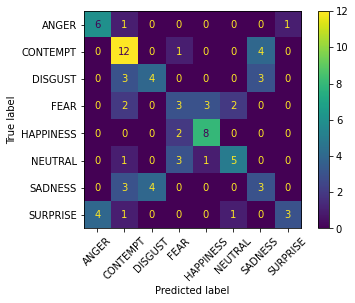

              precision    recall  f1-score   support

       ANGER       0.60      0.75      0.67         8
    CONTEMPT       0.52      0.71      0.60        17
     DISGUST       0.50      0.40      0.44        10
        FEAR       0.33      0.30      0.32        10
   HAPPINESS       0.67      0.80      0.73        10
     NEUTRAL       0.62      0.50      0.56        10
     SADNESS       0.30      0.30      0.30        10
    SURPRISE       0.75      0.33      0.46         9

    accuracy                           0.52        84
   macro avg       0.54      0.51      0.51        84
weighted avg       0.53      0.52      0.51        84



In [5]:
# Best parameters: (C=91, degree=4, kernel='poly')

model = SVC(C=120, degree=9, kernel='poly')
model.fit(train_x, train_y)
pred_y = model.predict(test_x)
show_metrics(model, pred_y, test_x, test_y)

Accuracy: 0.4166666666666667


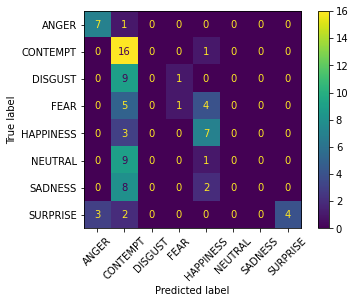

              precision    recall  f1-score   support

       ANGER       0.70      0.88      0.78         8
    CONTEMPT       0.30      0.94      0.46        17
     DISGUST       0.00      0.00      0.00        10
        FEAR       0.50      0.10      0.17        10
   HAPPINESS       0.47      0.70      0.56        10
     NEUTRAL       0.00      0.00      0.00        10
     SADNESS       0.00      0.00      0.00        10
    SURPRISE       1.00      0.44      0.62         9

    accuracy                           0.42        84
   macro avg       0.37      0.38      0.32        84
weighted avg       0.35      0.42      0.32        84



In [6]:
# Best C values: 85 160 564
model = LinearSVC(penalty='l2', C=85, max_iter=10000)
model.fit(train_x, train_y)
pred_y = model.predict(test_x)

show_metrics(model, pred_y, test_x, test_y)

In [7]:
np.random.seed(42)

# 'rbf', 'sigmoid'
param_grid = {
    'base_estimator':[DecisionTreeClassifier(max_depth=i) for i in range(4,10)],
    'learning_rate':np.logspace(-3, 2, 25, base = 10),
}

grid_search = GridSearchCV(AdaBoostClassifier(), param_grid=param_grid, verbose=True, n_jobs=4)
grid_search.fit(train_x, train_y)
print(grid_search.best_params_)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   17.1s
[Parallel(n_jobs=4)]: Done 200 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 466 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 750 out of 750 | elapsed:  3.3min finished
{'base_estimator': DecisionTreeClassifier(max_depth=7), 'learning_rate': 0.006812920690579615}


Accuracy: 0.4523809523809524


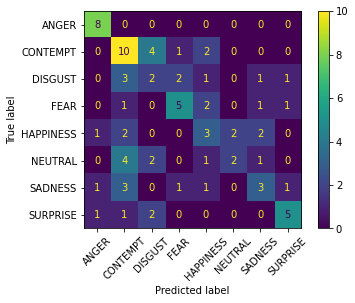

              precision    recall  f1-score   support

       ANGER       0.73      1.00      0.84         8
    CONTEMPT       0.42      0.59      0.49        17
     DISGUST       0.20      0.20      0.20        10
        FEAR       0.56      0.50      0.53        10
   HAPPINESS       0.30      0.30      0.30        10
     NEUTRAL       0.50      0.20      0.29        10
     SADNESS       0.38      0.30      0.33        10
    SURPRISE       0.62      0.56      0.59         9

    accuracy                           0.45        84
   macro avg       0.46      0.46      0.45        84
weighted avg       0.45      0.45      0.44        84



In [10]:
np.random.seed(42)

model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=7),learning_rate= 0.006812920690579615)
model.fit(train_x, train_y)
pred_y = model.predict(test_x)

show_metrics(model, pred_y, test_x, test_y)

In [9]:
tfeid_x = preprocess(tfeid_images)
tfeid_x = extract_features(tfeid_x, method=lbp)
tfeid_labels = np.array(tfeid_labels)

train_x, test_x, train_y, test_y = train_test_split(tfeid_x, tfeid_labels, stratify=tfeid_labels)

Accuracy: 0.40476190476190477


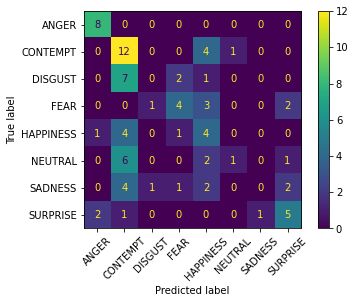

              precision    recall  f1-score   support

       ANGER       0.73      1.00      0.84         8
    CONTEMPT       0.35      0.71      0.47        17
     DISGUST       0.00      0.00      0.00        10
        FEAR       0.50      0.40      0.44        10
   HAPPINESS       0.25      0.40      0.31        10
     NEUTRAL       0.50      0.10      0.17        10
     SADNESS       0.00      0.00      0.00        10
    SURPRISE       0.50      0.56      0.53         9

    accuracy                           0.40        84
   macro avg       0.35      0.40      0.34        84
weighted avg       0.34      0.40      0.34        84



In [11]:
model = SVC(C=82, degree=8, kernel='poly')
model.fit(train_x, train_y)
pred_y = model.predict(test_x)
show_metrics(model, pred_y, test_x, test_y)

Accuracy: 0.35714285714285715


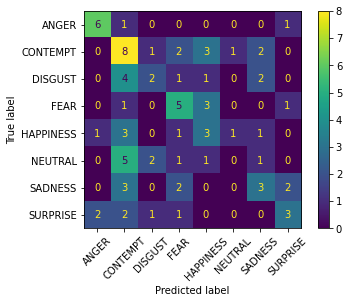

              precision    recall  f1-score   support

       ANGER       0.67      0.75      0.71         8
    CONTEMPT       0.30      0.47      0.36        17
     DISGUST       0.33      0.20      0.25        10
        FEAR       0.38      0.50      0.43        10
   HAPPINESS       0.27      0.30      0.29        10
     NEUTRAL       0.00      0.00      0.00        10
     SADNESS       0.33      0.30      0.32        10
    SURPRISE       0.43      0.33      0.38         9

    accuracy                           0.36        84
   macro avg       0.34      0.36      0.34        84
weighted avg       0.33      0.36      0.33        84



In [12]:
np.random.seed(42)

model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5),learning_rate= 2.154)
model.fit(train_x, train_y)
pred_y = model.predict(test_x)

show_metrics(model, pred_y, test_x, test_y)